In [36]:
import sys
sys.path.insert(0, '../')
from lib import *

DEBUG=False

%matplotlib inline

In [37]:
#LOAD AND REESCALE PROPERLY THE SERS
SiPM_SER=np.load  ("../../andres/run15_ch0/AveWvf.npz")["arr_0"][0]
XA_SER  =np.load  ("../../andres/run15_ch5/AveWvf.npz")["arr_0"][0]
SiPM_calib=np.load("../../andres/run25_ch0/AveWvfPeakAmpCharge.npz")["arr_0"][0]
XA_calib  =np.load("../../andres/run25_ch5/AveWvfAmpCharge.npz")["arr_0"][0]

if DEBUG:
    plt.plot(SiPM_SER[1000:1100])
    plt.plot(XA_SER  [1000:1100])
    plt.figure()
    plt.plot(SiPM_calib[1000:1100])
    plt.plot(XA_calib  [1000:1100])

#reescale the sers to match SPE charge(aprox):
            #SPE charge                   #High lum charge
SiPM_SER*=np.sum(SiPM_calib[1000:1100])/np.sum(SiPM_SER[1000:1100])
XA_SER  *=np.sum(XA_calib  [1000:1100])/np.sum(XA_SER  [1000:1100])

if DEBUG:
    plt.plot(SiPM_SER[1000:1100])
    plt.plot(XA_SER  [1000:1100])

# Align them at the begining 
SiPM_SER[0:4000]=SiPM_SER[1000:5000]
XA_SER  [0:4000]=XA_SER  [1000:5000]

SiPM_SER[4000:]*=0;
XA_SER  [4000:]*=0;

XA_SER_FFT  =np.fft.rfft(XA_SER) 
SiPM_SER_FFT=np.fft.rfft(SiPM_SER) 

In [38]:
# path="/media/rodrigoa/DiscoDuro/SBND_XA_PDE/APSAIA_VIS/joython/"
# for run in range(6,7):
# for run in range(0,1):
# for run in range(4,5):

path="/media/rodrigoa/DiscoDuro/SBND_XA_PDE/APSAIA_VUV/joython/"
for run in range(1):

    if run==3:continue # Rodrigo forgot one run :D
    Run_props=open_run_properties(run,"../macros/Runs_list.xlsx")
    run_path=path+"run"+str(run).zfill(2)+"/";

    compress=False
    
    
    # One channel at a time: 
    # loading all ch waveforms might demmand too much memory, 
    # remember to always delete between runs to prevent overloading)

    # for ch in Run_props["Channels"]:
    CH=0
    for ch in [CH]:

        ADC=open_run_var(run_path,"RawADC",[ch],compressed=True)
        Pedestal_vars=open_run_var(run_path,"Pedestal_vars",[ch],compressed=compress)
        ADC=do_run_things((ADC,Pedestal_vars,Run_props["Polarity"]),substract_Pedestal)
        
        Peak_vars=do_run_things(ADC,compute_Peak)

        # # Average_waveform
        # del Pedestal_vars, ADC
        
        # plt.plot(Avg_wvf[0])
        # Avg_wvf=do_run_things((ADC,{0:"shifted"},{0:c}),Average_waveform)
        # plt.plot(Avg_wvf[0])

----------
Doing:  substract_Pedestal  on channel: 0
----------
Doing:  compute_Peak  on channel: 0


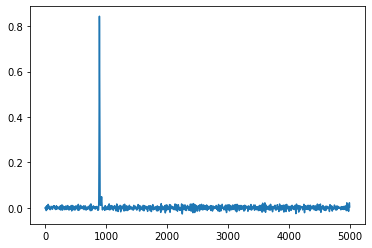

In [39]:
gauss_F=gauss(np.arange(len(SiPM_SER_FFT)),sigma=200,n=2)

ADC_DEC=deconvolve(ADC[0],SiPM_SER,gauss_F)
ADC_DEC
plt.plot(ADC_DEC[0])

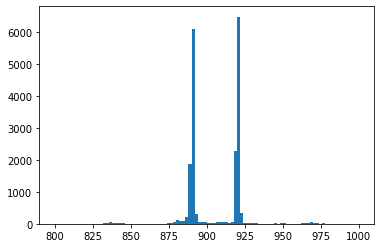

In [40]:
%matplotlib inline
plt.hist(np.argmax(ADC_DEC,axis=1),100,[800,1000]);
PEAK=np.argmax(ADC_DEC,axis=1)
CUTPEAK=PEAK>810

20433 total events
16538 events after all cuts( 80 %)
27.517740304808036 Hz


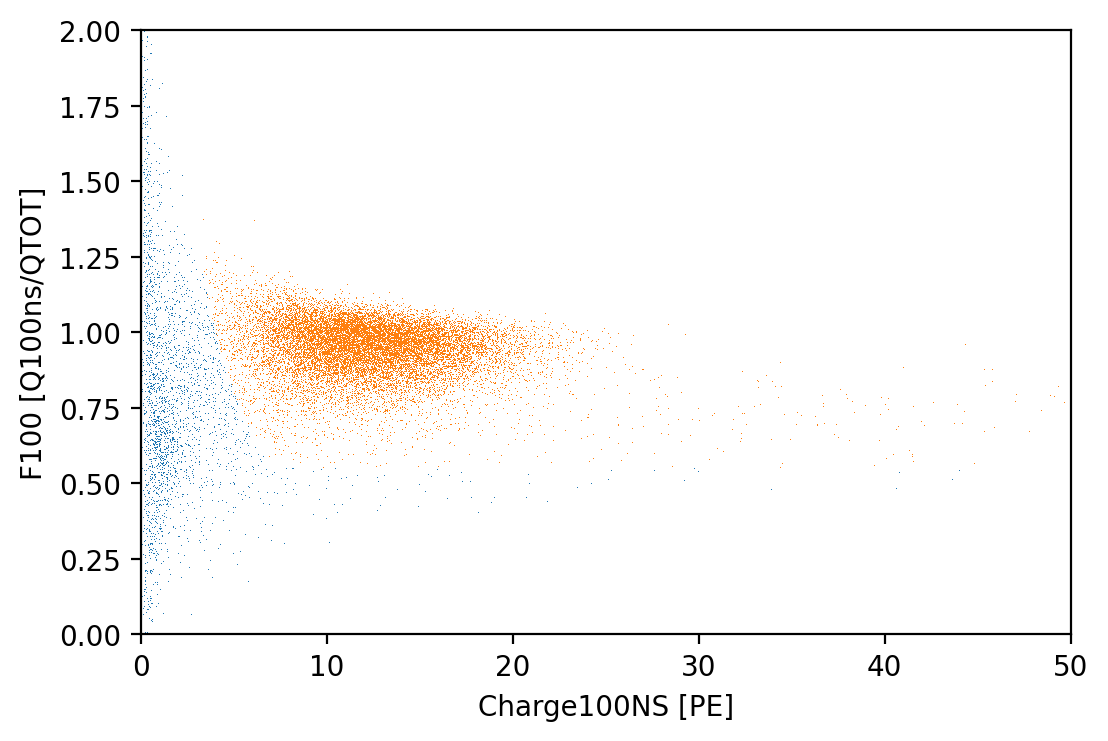

In [41]:
fast =np.sum(ADC_DEC[:,:945] ,axis=1)
total=np.sum(ADC_DEC[:,:1500],axis=1)

CUT_F90 =(fast/total)>0.55
CUT_FAST=4<fast

plt.figure(dpi=200)
plt.plot(total,fast/total,',',linewidth=0,markersize=0.05)
plt.plot(total[CUT_F90*CUT_FAST],(fast/total)[CUT_F90*CUT_FAST],',',linewidth=0,markersize=0.05)
plt.ylim([0,2])
plt.xlim([0,50])
plt.xlabel("Charge100NS [PE]")
plt.ylabel("F100 [Q100ns/QTOT]")

EV=np.sum(CUT_F90*CUT_FAST)


print(len(CUT_F90),"total events")
print(EV,"events after all cuts(",int(EV/len(CUT_F90)*100),"%)")

TS=open_run_var(run_path,"Timestamp",[CH],compressed=compress)

duration=(TS[0][-1]-TS[0][0])

print(EV/duration,"Hz")

In [42]:
%matplotlib qt

peaks = 1000-np.argmax (ADC_DEC[CUT_F90*CUT_FAST],axis=1)
wvff=Average_waveform  (ADC_DEC[CUT_F90*CUT_FAST],mode="shifted",shift=peaks)

wvff[wvff<0]=1e-10

In [45]:
start=1100
stop =start+425

coef = np.polyfit(range(wvff[start:stop].shape[0]),np.log(wvff[start:stop]),1)
poly1d_fn = np.poly1d(coef) 

plt.plot(np.log(wvff))
plt.plot(range(start,stop),poly1d_fn(range(stop-start)))

sampling=4#ns
print(sampling*coef[0]**-1)

-443.5626576878577


qt.qpa.wayland: Creating a fake screen in order for Qt not to crash
qt.qpa.wayland: Creating a fake screen in order for Qt not to crash
qt.qpa.wayland: Creating a fake screen in order for Qt not to crash
